# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [29]:
from tensorflow.keras.applications import EfficientNetB4

def build_efficientnet_model(audio_features, learning_rate=0.00005, num_classes=20):
    tf.keras.backend.clear_session()

    # Load EfficientNetB0 with ImageNet weights, excluding the top layer
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Input layer for the audio features
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]), name='Audio_Features')

    # Extract features using the base model
    features = base_model(inputs)

    # Add a global average pooling layer
    features = tf.keras.layers.GlobalAveragePooling2D()(features)

    # Add a custom fully connected (dense) layer
    features = tf.keras.layers.Dense(
        units=512,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        name='fc_1')(features)

    # Add dropout layer for regularization
    features = tf.keras.layers.Dropout(rate=0.3)(features)

    # Output layer with softmax activation
    outputs = tf.keras.layers.Dense(
        units=num_classes,
        activation='softmax',
        name='fc_output')(features)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='EfficientNet_Audio_Classification')

    print(model.summary())

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [30]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_EfficientNetB0.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [31]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [32]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [33]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs and Chroma

In [34]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [35]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [36]:
model = build_efficientnet_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "EfficientNet_Audio_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 4, 9, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,602,099 (70.96 MB)

 Trainable params: 928,276 (3.54 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 98s 342ms/step - accuracy: 0.1111 - loss: 10.2462 - val_accuracy: 0.2007 - val_loss: 8.4777
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.1271 - loss: 8.0944 - val_accuracy: 0.1044 - val_loss: 6.8764
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.1359 - loss: 6.5910 - val_accuracy: 0.1044 - val_loss: 5.7300
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.1273 - loss: 5.5692 - val_accuracy: 0.1044 - val_loss: 4.9199
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.1344 - loss: 4.8122 - val_accuracy: 0.1044 - val_loss: 4.3517
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.1289 - loss: 4.2910 - val_accuracy: 0.1044 - val_loss: 3.9393
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.1287 - loss: 3.8993 - val_accuracy: 0.1044 - val_loss: 3.6557
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.1357 - loss: 3.

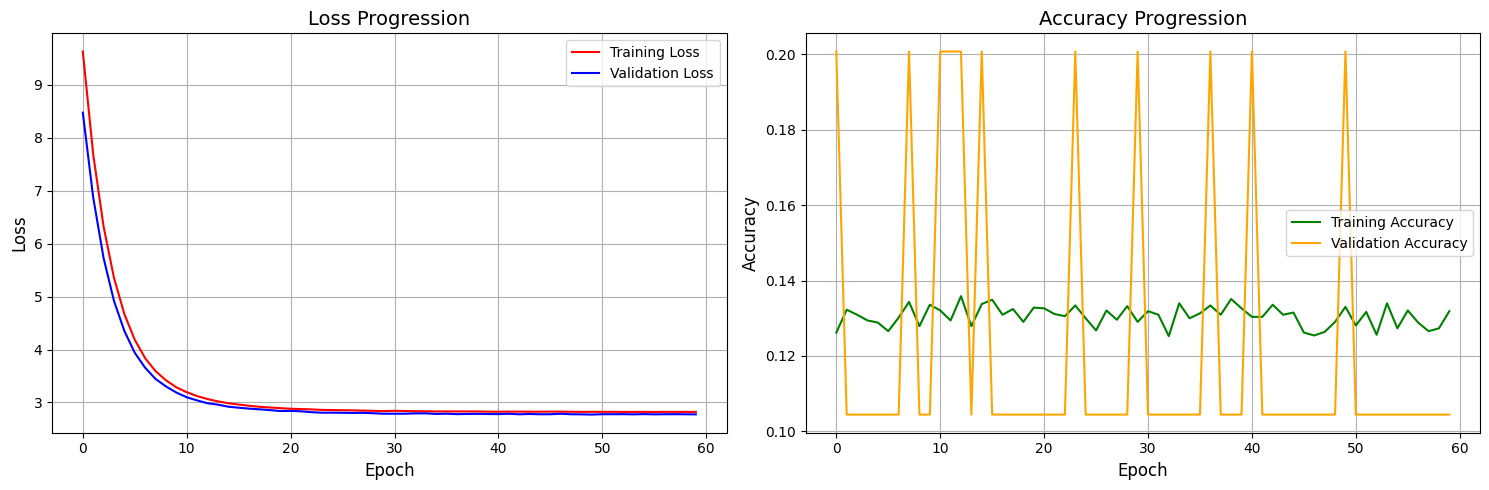

In [37]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [38]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.1301 - loss: 2.8086
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.1061 - loss: 2.7734


In [39]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.10      1.00      0.19       141
           2       0.00      0.00      0.00       271
           3       0.00      0.00      0.00        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        54
          13       0.00      0.00      0.00        48
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       117
          16       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Mel Spectrogram and MFCCs

In [40]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [41]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [42]:
model = build_efficientnet_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "EfficientNet_Audio_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 4, 9, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,602,099 (70.96 MB)

 Trainable params: 928,276 (3.54 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 83s 287ms/step - accuracy: 0.1486 - loss: 10.2221 - val_accuracy: 0.3874 - val_loss: 8.4985
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.2866 - loss: 8.0582 - val_accuracy: 0.4259 - val_loss: 6.8871
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.3278 - loss: 6.5780 - val_accuracy: 0.4119 - val_loss: 5.7692
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.3553 - loss: 5.5503 - val_accuracy: 0.4311 - val_loss: 4.9433
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.3803 - loss: 4.7553 - val_accuracy: 0.4244 - val_loss: 4.3543
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.3801 - loss: 4.1931 - val_accuracy: 0.4348 - val_loss: 3.8959
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.3911 - loss: 3.7653 - val_accuracy: 0.4437 - val_loss: 3.5403
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.3891 - loss: 3.

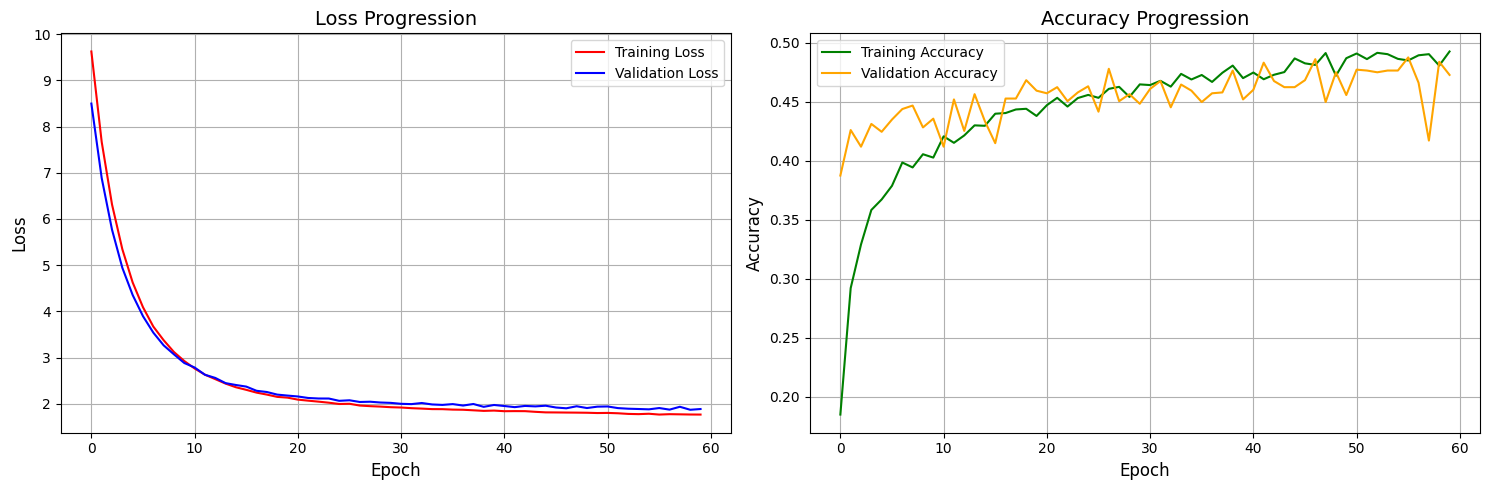

In [43]:
visualize(history, 'mfcc_melspectrogram')

In [44]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5610 - loss: 1.6315
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4747 - loss: 1.8788


In [45]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.47      0.55      0.51       114
           1       0.52      0.45      0.48       141
           2       0.75      0.76      0.76       271
           3       0.43      0.44      0.44        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        23
           7       0.91      0.98      0.95        44
           8       0.00      0.00      0.00        50
           9       0.73      0.33      0.45        49
          10       0.00      0.00      0.00        48
          11       0.50      0.04      0.08        46
          12       0.43      0.98      0.60        54
          13       0.14      0.21      0.17        48
          14       0.00      0.00      0.00        38
          15       0.40      0.39      0.40       117
          16       0.26      1.00      0.41   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Mel Spectrogram and MFCCs

In [48]:
# Train features
target_size = 128
training_features = np.stack((train_features['melspectrogram'], train_features['melspectrogram'], train_features['melspectrogram']), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [49]:
# Validation Features
target_size = 128

validation_features = np.stack((val_features['melspectrogram'], val_features['melspectrogram'], val_features['melspectrogram']), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [50]:
model = build_efficientnet_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "EfficientNet_Audio_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 4, 9, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,602,099 (70.96 MB)

 Trainable params: 928,276 (3.54 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 81s 279ms/step - accuracy: 0.1011 - loss: 10.2807 - val_accuracy: 0.2007 - val_loss: 8.4603
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.1366 - loss: 8.0531 - val_accuracy: 0.1044 - val_loss: 6.8341
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.1186 - loss: 6.5642 - val_accuracy: 0.1044 - val_loss: 5.6640
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.1419 - loss: 5.4881 - val_accuracy: 0.2007 - val_loss: 4.8560
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.1279 - loss: 4.7516 - val_accuracy: 0.2007 - val_loss: 4.2821
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.1232 - loss: 4.2317 - val_accuracy: 0.2007 - val_loss: 3.8777
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.1334 - loss: 3.8553 - val_accuracy: 0.2007 - val_loss: 3.6050
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.1255 - loss: 3.

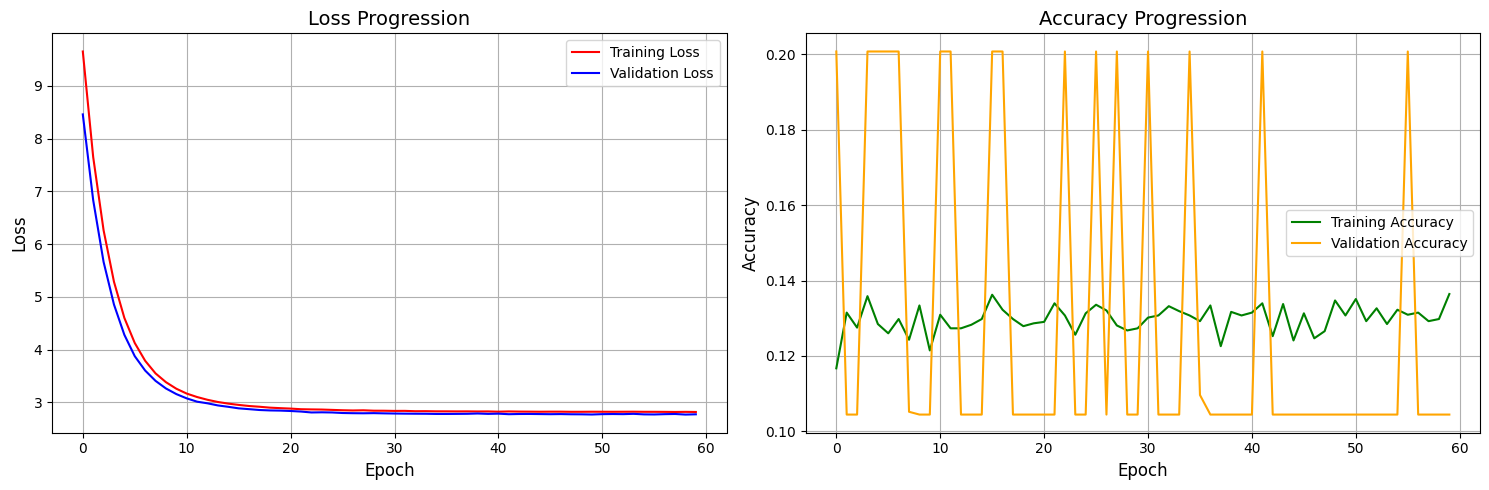

In [51]:
visualize(history, 'melspectrogram')

In [52]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.1301 - loss: 2.8090
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1061 - loss: 2.7755


In [53]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.10      1.00      0.19       141
           2       0.00      0.00      0.00       271
           3       0.00      0.00      0.00        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        54
          13       0.00      0.00      0.00        48
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       117
          16       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Review all the results

In [54]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
2,melspectrogram,0.134,0.104
0,melspectrogram_chroma_mfcc,0.134,0.104
1,mfcc_melspectrogram,0.548,0.473


In [55]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
2              melspectrogram     0.020      0.743
0  melspectrogram_chroma_mfcc     0.020      0.672
1         mfcc_melspectrogram     0.438      0.900
